In [2]:
import pandas as pd
import numpy as np
import math
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import folium

PATH = "Project3_Data\dataset_NYC.txt"
columns = ['UserID', 'VenueID', 'VenueCategoryID', 'VenueCategoryName', 'Latitude', 'Longitude', 'TimezoneOffsetInMin',
           'UTCTime']
df = pd.read_csv(PATH, sep="\t", encoding_errors='ignore', names=columns)


# 1.
# goal of the task: recommend 10 unvisited locations to given UID having similar category with given CategoryID
# @input: random UID, CategoryID
# @output: VenueID(location) list

def recommendVenueFromIDandCategory(inputUserID, inputCategory):
    clustered = clusterCategories()
    corr = getSimilarCategories(inputCategory, clustered)
    freq_category = getFreqCategory(inputUserID)
    freq_loc = getFreqLoc(freq_category)
    h, l = getOutlier(freq_loc['per'])

    # To select places that are not outliers calculated previously, create a standard value 'per' as a latitude/longitude ratio
    df['per'] = df['Latitude'] / df['Longitude']
    # Places close to previously found places & places not visited by the entered user ID
    candidate = df.loc[(l < df['per']) & (h > df['per']) & (df['UserID'] != inputUserID)]

    # Sorting in the order of places in the category found initially: The reason for sorting rather than selecting is that the selected places have similar conditions, so randomly selecting 10 of them can provide more diverse recommendations to users.
    i = 0
    for i in range(len(corr)):
        if i == 0:
            recommend = candidate[candidate['VenueCategoryName'] == corr.index[i]]
        else:
            recommend = pd.concat([recommend, candidate[candidate['VenueCategoryName'] == corr.index[i]]], axis=0)

    # To recommend VenueID(location) list, drop duplicates of VenueID
    recommend.drop_duplicates('VenueID', inplace=True)
    recommend = recommend[['VenueID', 'VenueCategoryName', 'Latitude', 'Longitude']]

    # it now recommends 10 top places from the df
    # might be fixed to recommend in various way
    recommend = recommend.head(10).values.tolist()
    return recommend


def getFreqCategory(inputUserID):
    # reframe data from UserID and VenueCategoryID
    gdf_categoryID = df.groupby(['UserID', 'VenueCategoryID']).size().reset_index()
    gdf_categoryID.columns = ['UserID', 'VenueCategoryID', 'N']
    re_user = pd.pivot_table(gdf_categoryID, index='UserID', columns='VenueCategoryID', values='N', fill_value=0)

    # make temporal data frame to count how many times inputUserId visit each places
    temp = re_user[re_user.index == inputUserID].transpose()
    # drop places where count = 0
    temp = temp[temp[inputUserID] != 0]

    # VenueCategoryID -> VenueCategoryName (to show data easily)
    temp_id = list()
    for _id in temp.index:
        temp_id.append(find_category_name_by_id(_id))
    temp['VenueCategoryName'] = temp_id

    # sort by visit frequencies
    temp = temp.sort_values(inputUserID, ascending=False)
    # drop places where freqeuncy < mean
    m = temp[inputUserID].mean()
    temp = temp[m < temp[inputUserID]]

    return temp


# Function that returns a data frame containing latitude and longitude information of places that inputUserID frequently visits
def getFreqLoc(freq_category):
    ## Based on frequency data, extract radius data of places frequented by users from actual latitude and longitude data

    # lat, lon info from places that inputUserID frequently visits data (freq.index: Category info of frequently visited places)
    freq_loc = pd.DataFrame()
    for _id in freq_category.index:
        _temp = df[df['VenueCategoryID'] == _id][['Latitude', 'Longitude']]
        freq_loc = pd.concat([freq_loc, _temp], axis=0)

    # drop duplicates of lat, lon (precise location info) : location info rather than frequency info will be used
    freq_loc = freq_loc.drop_duplicates(['Latitude', 'Longitude'])

    # Removing outliers (excluding too far places)
    # To calculate outliers, use the ratio of latitude and longitude to create a reference value
    freq_loc['per'] = freq_loc['Latitude'] / freq_loc['Longitude']

    return freq_loc


# Function that calculate IQR from given data and return its reference value
def getOutlier(data):

    # Q1 - 1.5 * IQR = lowest, Q3 + 1.5 * IQR = highest (IQR = Q3 - Q1)
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1

    h = q3 + 1.5 * iqr
    l = q1 - 1.5 * iqr

    return h, l


# Function that extracts only data belonging to the same cluster as inputCategory and returns data sorted in a similarity.
def getSimilarCategories(inputCategory, similar):
    # Extract frequently visited categories belonging to the same cluster as inputCategory
    # get cluster of inputCategory
    inputCluster = similar[similar.index == inputCategory]['cluster'][inputCategory]

    # pick data which have same cluster as input cluster
    similar = similar[similar['cluster'] == inputCluster]

    # sort by abs of differences
    similar['diff'] = similar['sum'].sub(similar[similar.index == inputCategory]['sum'][inputCategory]).abs()
    similar = similar.sort_values('diff')

    # drop where the value >= mean
    m = similar['diff'].mean()
    similar = similar[m > similar['diff']]

    return similar


# Function that clusters based on the frequency of visits for each place category and returns numbered data for places with similar visit frequencies
def clusterCategories():
    # reframe data by UserID, VenueCategoryName, and the frequency of visiting
    gdf = df.groupby(['UserID', 'VenueCategoryName']).size().reset_index()
    gdf.columns = ['UserID', 'VenueCategoryName', 'N']
    re_category = pd.pivot_table(gdf, index='VenueCategoryName', columns='UserID', values='N', fill_value=0)

    # Value correction: Find the percentage of frequency for each place category.
    corr = re_category.div(re_category.sum(axis=0)).mul(100)
    # to make calculations more convenient later, add up the numbers for each location.
    corr['sum'] = corr.sum(axis=1)

    ## cluster by corr['sum'] (= added freq for each location)

    # 10% sampling
    X_sample = corr[['sum']].sample(frac=0.1)
    # n in KMeans = sqrt of (data length/2)
    n = math.ceil(math.sqrt(corr.shape[0] / 2))
    # KMeans Clustering
    kmeans = KMeans(n_clusters=n, init='k-means++')
    kmeans.fit(X_sample)
    y = kmeans.labels_
    # add cluster number to data
    corr['cluster'] = kmeans.predict(corr[['sum']])

    return corr


# Function that finds VenueCategoryName by venueCategoryID
def find_category_name_by_id(_id):
    # drop duplicates of venueCategoryID: to find matching venueCategoryName easily
    df_unique_categoryID = df.drop_duplicates('VenueCategoryID')

    temp_cat = df_unique_categoryID[df_unique_categoryID['VenueCategoryID'] == _id]
    temp_cat.reset_index(drop=True, inplace=True)

    return temp_cat['VenueCategoryName'][0]


# 2.
# goal of the task: recommend the 10 most similar users with a randomly given user
# @input param: randomly given UserID
# @expected output: top 10 UserIds list with the most similar, interests match

def recommendUsersFromID(inputUserID):
    gdf = df.groupby(['UserID', 'VenueCategoryName']).size().reset_index()
    gdf.columns = ['UserID', 'VenueCategoryName', 'N']
    re_category = pd.pivot_table(gdf, index='VenueCategoryName', columns='UserID', values='N', fill_value=0)
    freq_id = re_category.transpose()

    # Cosine similarity: A method of calculating similarity using the angle between vectors; the closer the value is to 1, the more similar it is.
    # Calculate cosine similarity for each ID and retrieve the cosine similarity vector corresponding to the input userID
    freq_id['cos'] = cosine_similarity(freq_id)[inputUserID]

    # Sort the values in descending order, exclude the entered userID, and select the remaining top 10.
    most_similar = freq_id.sort_values('cos', ascending=False)[1:11].index

    return most_similar.values.tolist()


# 3.
# goal of the task: recommend meeting point with 5 randomly given users and their locations
# @input param: randomly given 5 UserIDs and their locations (Latitude, Longitude)
# @expected output: the location of recommended meeting point

# visualization
# Function that visually displays the locations of the original userID and suggested locations
def showMap(inputUserIDs, inputLocs, meetingPoint):
    mid = inputLocs.transpose().mean(axis=1)
    m = folium.Map(location=mid, zoom_start=10)

    for i in range(5):
        folium.Marker(inputLocs[i], tooltip=inputUserIDs[i]).add_to(m)

    folium.Marker(meetingPoint,
                  icon=folium.Icon(color='red', icon='star'),
                  tooltip='suggestPoint').add_to(m)

    return m


# Function that suggests the optimal meeting location from 5 userIDs and each location
def recommendMeetingPointFromIDsandLocs(inputUserIDs, inputLocs):
    # find mid point from 5 locations
    mid = inputLocs.transpose().mean(axis=1)

    # find VenueCategoryNames that suit each userID's tastes
    freq_categories = pd.DataFrame(columns=inputUserIDs)
    for i in range(5):
        temp = getFreqCategory(inputUserIDs[i])['VenueCategoryName']
        freq_categories = pd.concat([freq_categories, temp], axis=1)

    ## Select one category with the most overlap between categories
    temp_list = list(freq_categories)
    temp_set = list(set(temp))
    max = 0
    most_freq_category = temp_set[0]
    # find overlapping categories and their number, and find the category with the most overlap.
    for i in range(len(temp_set)):
        cnt = temp_list.count(temp_set[i])
        if cnt > max:
            max = cnt
            most_freq_category = temp_set[i]

    if max == 1:
        # If NO overlapping categories -> just recommend the closest location from mid.
        data = np.array(df[['Latitude', 'Longitude']])
    else:
        # If overlapping categories (O) -> recommend appropriate location by the most overlapping categories and mid location info
        data = np.array(df[df['VenueCategoryName'] == most_freq_category][['Latitude', 'Longitude']])

    meetingPoint = findNearestLoc(mid, data)

    return meetingPoint


# Function that finds the closest x,y to a random x,y among the x,y in the given data
def findNearestLoc(point, data):

    mn = 10000
    idx = 0

    for i in range(len(data)):

        # Euclidean distance
        s = np.sum((point - data[i]) ** 2)

        if s < mn:
            mn = s
            idx = i

    return data[i]


# Function that gets a UserID from the user
def getUserID():
    # 수정 1083
    while ((inputUserID := int(input("Enter UserID (from 1 to 1083): "))) < 1 or inputUserID > 1083):
        print("UserID Error")
        continue

    return inputUserID


# Function that gets a VenueCategoryName from the user
def getCategoryName():
    cnt = 0
    CategoryType = df['VenueCategoryName'].value_counts().index

    # Repeat until the data frame contains a CategoryName that contains the characters entered by the user
    while cnt >= 0:

        inputCategory = input("Enter VenueCategoryName: ")

        if inputCategory.strip() == "":
            pass

        # If a CategoryName contains characters entered by the user, return the exact CategoryName
        for _type in CategoryType:
            if inputCategory.strip() in _type:
                inputCategory = _type
                cnt = -1
                break

        if cnt >= 0:
            print("CategoryName Error")
            cnt += 1

    return inputCategory


# Function that gets 5 UserIDs from the user
def get_5_UserIDs():
    inputCheck = False

    while inputCheck == False:

        temp = input("Enter 5 UserID(from 1 to 1083)s: ").split()
        for i in range(len(temp)):
            temp[i] = temp[i].rstrip(r',$')
        inputUserIDs = list(map(int, temp))

        if (len(inputUserIDs) != 5):
            print("UserID Error (input 5 user ids)")
            continue

        i = 0
        for n in inputUserIDs:
            if n < 1 or n > 1083:
                print("UserID Error (" + n + " could not be accepted)")
                i += 1

        if i < 1:
            inputCheck = True

    return inputUserIDs


# Function that finds each Location from 5 UserIDs
def get_5_Locations(inputUserIDs):
    # get locations (lat, lon) for each UserID
    inputLocs = pd.DataFrame(columns=['Latitude', 'Longitude'])

    for i in range(5):

        while True:
            temp = list(input("Enter the location of UserID:" + str(inputUserIDs[i]) + " (lat, lon): ").split())

            if len(temp) != 2:
                print("Location Error (input latitude and longitude)")
                continue

            temp[0] = temp[0].rstrip(r',$')
            temp[1] = temp[1].rstrip(r',$')

            lat, lon = map(float, temp)

            if abs(lat) > 90:
                print("Latitude Range Error (it must be in range of (-90, 90))")
            elif abs(lon) > 180:
                print("Longitude Range Error (it must be in range of (-180, 180))")
            else:
                break

        inputLocs = pd.concat([inputLocs, pd.DataFrame({'Latitude': [lat], 'Longitude': [lon]})])

    inputLocs.index = inputUserIDs

    return inputLocs


############################## functions to operate in command line (for test)

# Task1
# recommend 10 unvisited locations to given UID having similar category with given CategoryID
def recommend_1():
    inputUserID = getUserID()
    inputCategory = getCategoryName()

    recommendedVenueIDs = recommendVenueFromIDandCategory(inputUserID, inputCategory)

    print(recommendedVenueIDs)

# Task2
# recommend the 10 most similar users with a randomly given user
def recommend_2():
    inputUserID = getUserID()

    recommendedUserIDs = recommendUsersFromID(inputUserID)

    print(recommendedUserIDs)

# Task3
# recommend meeting point with 5 randomly given users and their locations
def recommend_3():
    inputUserIDs = get_5_UserIDs()
    inputLocs = np.array(get_5_Locations(inputUserIDs))

    meetingPoint = recommendMeetingPointFromIDsandLocs(inputUserIDs, inputLocs)
    m = showMap(inputUserIDs, inputLocs, meetingPoint)

    print(meetingPoint)
    print(m)


# def main():
#
#     #clusterCategories()
#     #getSimilarCategories()
#     #recommend_1() # 1. recommend 10 unvisited locations to given UID having similar category with given CategoryID
#     #recommend_2() # 2. recommend the 10 most similar users with a randomly given user
#     #recommend_3() # 3. recommend meeting point with 5 randomly given users and their locations
#
#
# if __name__ == "__main__":
#     main()



#################################### functions to use in app.py
### functions to operate when parameters are given

# Task1
# recommend 10 unvisited locations to given UID having similar category with given CategoryID
def recommend_1_with_param(inputUserID, inputCategory):
    recommendedVenueIDs = recommendVenueFromIDandCategory(inputUserID, inputCategory)
    print(recommendedVenueIDs)
    return recommendedVenueIDs

# Task2
# recommend the 10 most similar users with a randomly given user
def recommend_2_with_param(inputUserID):
    recommendedUserIDs = recommendUsersFromID(inputUserID)
    print(recommendedUserIDs)
    return recommendedUserIDs

# Task3
# recommend meeting point with 5 randomly given users and their locations
def recommend_3_with_param(inputUserIDs, inputLocs):
    inputLocs = np.array(inputLocs)
    meetingPoint = recommendMeetingPointFromIDsandLocs(inputUserIDs, inputLocs)
    m = showMap(inputUserIDs, inputLocs, meetingPoint)

    m.save('templates/r3_out_map.html')

    # # save img
    # options = webdriver.ChromeOptions()
    # options.add_argument('--headless')
    # # options.add_experimental_option("detach", True)
    # service = Service(executable_path=r"C:/chromedriver/chromedriver.exe")
    # driver = webdriver.Chrome(service=service, options=options)
    #
    # img_data = m._to_png(5, driver=driver)
    # img = Image.open(io.BytesIO(img_data))
    # img.save('r3_out_map.png')

    return meetingPoint.tolist()

def checkUserID(inputUserID):

    # inputUserID range : 1 ~ 1083
    if inputUserID < 1 or inputUserID > 1083:
        return False
    else:
        return True

def checkCategory(inputCategory):

    # every category type given
    CategoryType = df['VenueCategoryName'].value_counts().index

    # If a CategoryName contains characters entered by the user, return the exact CategoryName
    for _type in CategoryType:
        if inputCategory.strip() in _type:
            inputCategory = _type
            return inputCategory

    # If there is no matching category, return false
    return False


In [4]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [7]:
clustered = clusterCategories()

C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [9]:
gdf = df.groupby(['UserID', 'VenueCategoryName']).size().reset_index()
gdf.columns = ['UserID', 'VenueCategoryName', 'N']
re_category = pd.pivot_table(gdf, index='VenueCategoryName', columns='UserID', values='N', fill_value=0)
corr = re_category.div(re_category.sum(axis=0)).mul(100)
corr['sum'] = corr.sum(axis=1)

In [19]:
score_samples = silhouette_samples(corr[['sum']], clustered['cluster'])
average_score = silhouette_score(corr[['sum']], clustered['cluster'])
clustered['silhouette_coeff'] = score_samples
silhouette_coeff_mean = clustered.groupby('cluster')['silhouette_coeff'].mean()

In [13]:
score_samples

array([ 0.75899342,  0.69153976,  0.57489345,  0.52343745,  0.47203892,
        0.81691649,  0.791975  ,  0.66299327,  0.81566032,  0.81963256,
        0.2290861 ,  0.71752432,  0.56937572,  0.43170037,  0.76637294,
        0.77560674,  0.06518239,  0.78355233,  0.70931623,  0.13260055,
        0.31181875,  0.30904675,  0.51812135,  0.63995134,  0.49118345,
        0.76321347,  0.34040464,  0.80759871,  0.74298812,  0.73494946,
       -0.00565273,  0.1738132 ,  0.66210378,  0.54642324,  0.69470213,
        0.62240243,  0.56108894,  0.79758275,  0.6403345 ,  0.5224708 ,
        0.7204411 ,  0.79782206,  0.49985161,  0.49645471,  0.81697321,
        0.8193572 ,  0.78981033,  0.28865746,  0.7502111 ,  0.57949986,
        0.38244153,  0.0956084 ,  0.62120097,  0.61869662,  0.42150809,
        0.63506482,  0.63737245,  0.70668845,  0.78174737,  0.64651837,
        0.78829377,  0.75365762,  0.72496198,  0.22700822,  0.77526455,
        0.61016527,  0.56217091,  0.13196961,  0.68460289,  0.64

In [14]:
average_score

0.5564947884123094

In [15]:
clustered.shape

(251, 1086)

In [16]:
clustered

UserID,1,2,3,4,5,6,7,8,9,10,...,1077,1078,1079,1080,1081,1082,1083,sum,cluster,silhouette_coeff
VenueCategoryName,,,,,,,,,,,,,,,,,,,,,
Afghan Restaurant,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,2.008710,3,0.758993
African Restaurant,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.352113,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,30.078779,3,0.691540
Airport,2.830189,0.000000,6.779661,0.000000,0.0,1.162791,0.000000,5.511811,0.000000,1.675978,...,0.000000,0.000000,1.470588,2.34375,0.0,2.713178,0.000000,1565.016042,4,0.574893
American Restaurant,9.433962,2.631579,16.949153,0.571429,0.0,0.387597,1.408451,3.937008,4.142012,0.558659,...,0.000000,0.641026,2.205882,3.90625,0.0,0.000000,1.086957,2051.448693,4,0.523437
Animal Shelter,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.769231,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,37.480484,3,0.472039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Video Store,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,18.353382,3,0.813431
Vietnamese Restaurant,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.362319,111.452544,7,-0.278790
Winery,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,17.554208,3,0.816273


In [18]:
score_samples.shape

(251,)

In [20]:
silhouette_coeff_mean

cluster
0     0.652832
1     0.294036
2    -0.025293
3     0.731083
4     0.303363
5     0.560557
6     0.389463
7     0.409183
8     0.658116
9     0.587739
10    0.652610
11    0.523043
Name: silhouette_coeff, dtype: float64

In [28]:
# Function that clusters based on the frequency of visits for each place category and returns numbered data for places with similar visit frequencies
def clusterCategories(v):
    # reframe data by UserID, VenueCategoryName, and the frequency of visiting
    gdf = df.groupby(['UserID', 'VenueCategoryName']).size().reset_index()
    gdf.columns = ['UserID', 'VenueCategoryName', 'N']
    re_category = pd.pivot_table(gdf, index='VenueCategoryName', columns='UserID', values='N', fill_value=0)

    # Value correction: Find the percentage of frequency for each place category.
    corr = re_category.div(re_category.sum(axis=0)).mul(100)
    # to make calculations more convenient later, add up the numbers for each location.
    corr['sum'] = corr.sum(axis=1)

    ## cluster by corr['sum'] (= added freq for each location)

    # 10% sampling
    X_sample = corr[['sum']].sample(frac=0.1)
    # n in KMeans = sqrt of (data length/2)
    n = math.ceil(math.sqrt(corr.shape[0] / 2)) + v
    # KMeans Clustering
    kmeans = KMeans(n_clusters=n, init='k-means++')
    kmeans.fit(X_sample)
    y = kmeans.labels_
    # add cluster number to data
    corr['cluster'] = kmeans.predict(corr[['sum']])

    return corr

In [73]:
def test(v):
    clustered = clusterCategories(v)
    gdf = df.groupby(['UserID', 'VenueCategoryName']).size().reset_index()
    gdf.columns = ['UserID', 'VenueCategoryName', 'N']
    re_category = pd.pivot_table(gdf, index='VenueCategoryName', columns='UserID', values='N', fill_value=0)
    corr = re_category.div(re_category.sum(axis=0)).mul(100)
    corr['sum'] = corr.sum(axis=1)
    
    score_samples = silhouette_samples(corr[['sum']], clustered['cluster'])
    average_score = silhouette_score(corr[['sum']], clustered['cluster'])
    clustered['silhouette_coeff'] = score_samples
    silhouette_coeff_mean = list(clustered.groupby('cluster')['silhouette_coeff'].mean())
    silhouette_coeff_size = list(clustered.groupby('cluster')['silhouette_coeff'].size())
    
    print(average_score)
    print(len(silhouette_coeff_mean), silhouette_coeff_mean)
    print(len(silhouette_coeff_size), silhouette_coeff_size)

In [74]:
test(0)

C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


0.5566998167463053
12 [0.7081066238302031, 0.23588887574963424, 0.5482199625282005, 0.5001092380052695, 0.3103463066439066, 0.6922336010043022, 0.17509057448441867, 0.5205433164844063, 0.6901624099261977, 0.47963580102100306, 0.8850510363217294, 0.5082893227426776]
12 [7, 6, 40, 13, 13, 20, 15, 6, 78, 21, 3, 29]


In [75]:
test(1)

C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


0.47478949101718193
13 [0.3167749632283833, 0.5908077597283239, 0.9312019793622361, 0.5897471756698146, 0.357917733394339, 0.34454059990417835, 0.5590660452210158, -0.2925976917554925, 0.6065277775127554, 0.6372446867902776, 0.6942412869174567, 0.5355529916568749, 0.7316008506379904]
13 [34, 4, 4, 3, 52, 18, 24, 11, 5, 23, 2, 28, 43]


In [76]:
test(2)

C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


0.4972986185872691
14 [0.5296266695155443, 0.47951144739758156, 0.41855417034462017, 0.3956748418831818, 0.6429598748725867, 0.22252985564164146, 0.4902411922977146, 0.40029510583169553, 0.6625207045007907, -0.14048697704282145, 0.6189208162344406, 0.6323142048776668, 0.6406664189052336, 0.7264902833055404]
14 [9, 4, 33, 4, 2, 26, 19, 52, 19, 5, 4, 11, 18, 45]


In [77]:
test(3)

C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


0.4948429495755668
15 [0.6780477109401152, 0.6653001740431808, -0.0072917526055653464, 0.6424637286184305, 0.5745273342900888, 0.5858106711917949, 0.2179618210979452, 0.30573517335892136, 0.4194103094457257, 0.5057802355569707, 0.09407938844544131, 0.3422201774126114, 0.6612591864887982, 0.5978325379653487, 0.5793476771226673]
15 [13, 7, 8, 35, 10, 7, 14, 21, 6, 10, 5, 31, 10, 46, 28]


In [78]:
test(4)

C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


0.525443847229869
16 [0.504650958355038, 0.5529344811626083, 0.43133373965973437, -0.18652903118506395, 0.8384097129450313, 0.48334210843442676, 0.3379340606152645, 0.7347741624159051, 0.6108064469068325, 0.4824726575101426, 0.5930401115350751, 0.48715737264500963, 0.49457937603488006, 0.5907420820977727, 0.4681041231870434, 0.9586614265081803]
16 [7, 19, 6, 11, 8, 9, 8, 13, 71, 14, 5, 11, 21, 14, 32, 2]


In [79]:
test(5)

C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


0.44152405116300386
17 [0.7042780599209287, 0.23901595657886093, -0.3491354447072623, 0.2861137991024416, 0.38675883967291136, 0.5455377877608688, 0.020307282461098197, 0.7718337403337796, 0.5171925303496265, 0.5873748824744401, 0.17250181901051448, 0.6524369247993201, 0.4672221601729636, 0.6445248070014498, 0.687969885939292, 0.4873526179457642, 0.4770701907806257]
17 [25, 5, 18, 11, 17, 20, 4, 4, 9, 28, 19, 12, 13, 19, 6, 28, 13]


In [80]:
test(6)

C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


0.43208817270238914
18 [0.39085178188439224, 0.718808750440905, 0.4592324926913847, -0.15144318613328192, 0.5764029874833684, 0.6298448205786642, 0.5641953262965259, 0.1922129458187727, -0.018562726765221874, 0.4475006496341365, 0.15540731179685893, 0.5218870548583798, 0.5534489570659045, 0.46436284504095937, 0.7112783563637681, 0.6572308217243076, 0.6699303421907558, 0.5648275123297555]
18 [12, 3, 14, 10, 8, 16, 8, 12, 9, 44, 23, 21, 9, 19, 5, 9, 14, 15]


In [81]:
test(7)

C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


0.38844359844860127
19 [0.6915641231373051, 0.04153513280061343, -0.24696092973193573, 0.9993628664957883, 0.4779426301404431, 0.31331047269145135, 0.5606313358861681, 0.3882158052100077, 0.5907028625691941, 0.3110710900228778, 0.2745138827824758, 0.47432930556141456, 0.27888783661655314, 0.44657764333637856, 0.2971637492481782, 0.0, 0.690135444323953, 0.7169824776111507, 0.42013707810623624]
19 [19, 7, 20, 2, 27, 11, 3, 9, 21, 19, 5, 15, 38, 12, 7, 1, 11, 10, 14]


In [82]:
test(8)

C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


0.38565906579541975
20 [0.3626798876387895, 0.5708788152542313, 0.6094123686070047, 0.46180267993452684, 0.7071365810816889, 0.14666893823931437, 0.41810433571147215, 0.3934293714443548, 0.3018091091893892, 0.4715075552848703, 0.5532010001800547, 0.4419886870413545, -0.310282345912726, 0.32634176666702813, 0.36789755661784235, 0.6595241645908024, 0.25960247179927126, 0.4793444482022549, 0.6009145883991852, 0.6557644188138859]
20 [6, 14, 6, 13, 11, 18, 6, 10, 21, 16, 11, 25, 22, 11, 15, 10, 2, 11, 12, 11]


In [83]:
test(9)

C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


0.37448281045530174
21 [0.44289825134606675, 0.09137162064030159, 0.6658602761971791, 0.6342699414718372, 0.26652679041607114, -0.2903650996790189, 0.6569125333044956, 0.3778501893013577, 0.375213189459027, 0.423266981945163, 0.6483207264213097, 0.5910306978247512, 0.6519881021966374, 0.6027159804660267, 0.8372559142578236, 0.5170666434431256, 0.5076582566439324, 0.37086104155316196, 0.5079055527670499, 0.37459459935708916, -0.05017496008048363]
21 [21, 14, 7, 3, 16, 20, 3, 23, 21, 31, 3, 14, 5, 3, 6, 25, 5, 13, 5, 10, 3]


In [84]:
test(10)

C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


0.41595609586327603
22 [0.48544910893143384, 0.7779696461260722, 0.8724970460746154, 0.15580047821901236, 0.2714553510728582, 0.22397779711311022, 0.6625536073977247, 0.20561880366094598, 0.44457631327564, 0.46075673147268703, 0.6688363875320217, 0.40586658785249646, 0.5446238199339241, 0.0, 0.19694007529260976, 0.4296963338423561, -0.23518579550628335, 0.4379582037675447, 0.7149439426785145, 0.45320708243593183, 0.6226116853620556, 0.6423617745689891]
22 [24, 8, 3, 6, 14, 9, 2, 15, 8, 13, 8, 26, 22, 1, 17, 16, 12, 8, 21, 11, 4, 3]


In [85]:
test(-1)

C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


0.5634912222438587
11 [0.23332965464742467, 0.6349414551687362, 0.4587098813209028, 0.6282858981125581, -0.0683918881657434, 0.26237131048433643, 0.47361573681639546, 0.6407589512981429, 0.7223230346890417, 0.6255678060134727, 0.5897922442300936]
11 [14, 2, 46, 10, 8, 11, 15, 22, 100, 5, 18]


In [86]:
test(-2)

C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


0.5065628190278963
10 [0.8610979165087005, 0.6275816896060583, -0.2727232715793145, 0.5082424741414994, 0.5050921928487427, 0.4631493287032177, 0.7045085772518412, 0.5328457131391684, 0.4515121841554401, 0.5689714577802597]
10 [3, 24, 25, 42, 9, 22, 81, 25, 13, 7]


In [88]:
test(-3)

C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


0.44303952824802834
9 [0.4965234062526403, 0.6244821324091829, 0.4264857142663499, -0.29046904973948595, 0.5857979341844798, 0.5195692628881352, 0.33571171166715275, 0.7029878773423035, 0.3414204158035077]
9 [45, 10, 28, 27, 7, 13, 8, 73, 40]


In [89]:
test(-4)

C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


0.5666973916407763
8 [0.6876486404672975, 0.6292112806340938, 0.5159969413638726, 0.11348092742384966, 0.47414975249576125, 0.46032874614003216, 0.7271015390642706, 0.47207720656491947]
8 [13, 4, 47, 20, 20, 10, 100, 37]


In [90]:
test(-5)

C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


0.43084508384135517
7 [-0.2923228452258715, 0.4022600280586577, 0.6493730969604589, 0.42069434755584356, 0.42654800670140103, 0.6079898308572006, 0.735047985713414]
7 [34, 40, 13, 52, 30, 11, 71]


In [91]:
test(-6)

C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


0.47255678749145247
6 [0.7735091240804867, 0.47414975249576125, -0.2923228452258715, 0.5032376689436628, 0.7274578164179739, 0.38851164516418546]
6 [88, 20, 34, 37, 13, 59]


C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

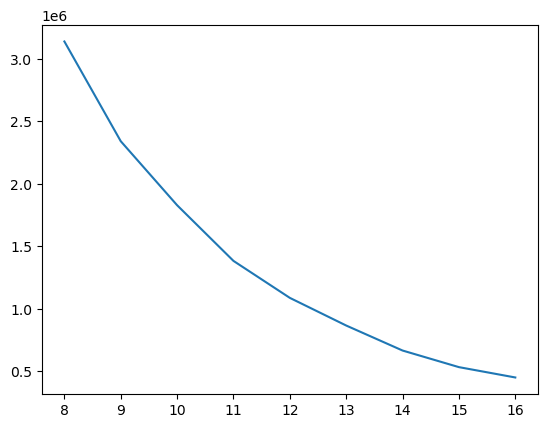

In [92]:
import seaborn as sns

gdf = df.groupby(['UserID', 'VenueCategoryName']).size().reset_index()
gdf.columns = ['UserID', 'VenueCategoryName', 'N']
re_category = pd.pivot_table(gdf, index='VenueCategoryName', columns='UserID', values='N', fill_value=0)
corr = re_category.div(re_category.sum(axis=0)).mul(100)
corr['sum'] = corr.sum(axis=1)
X_sample = corr[['sum']].sample(frac=0.1)

def visualize_inertia(cluster_lists, X_features):
    inertias = []
    for n_cluster in cluster_lists:
        k_means = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        k_means.fit(X_features)
        inertias.append(k_means.inertia_)
        
    sns.lineplot(x=cluster_lists, y=inertias)
    
visualize_inertia([i for i in range(8, 17)], corr[['sum']])

C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jweun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

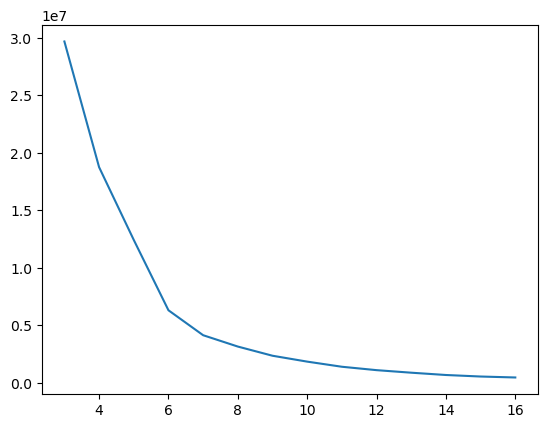

In [95]:
visualize_inertia([i for i in range(3, 17)], corr[['sum']])

In [96]:
math.ceil(math.sqrt(corr.shape[0] / 2))

12

In [97]:
math.sqrt(corr.shape[0] / 2)

11.20267825120404